In [ ]:
import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
# import dataset, network to train and metric to optimize
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, QuantileLoss, GroupNormalizer
from lightning.pytorch.tuner import Tuner
import torch
from pytorch_forecasting.metrics import MAE


In [2]:
import pandas as pd
Final_DataFrame = pd.read_csv('Final_DF.csv')

In [4]:
Final_DataFrame.head()

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,BTC_Price,ETH_Price,SOL_Price,XRP_Price
0,2020-04-10,99.519997,1662.50,0.05,0.729,41.67,6865.493164,158.412445,0.951054,0.187464
1,2020-04-11,99.519997,1662.50,0.05,0.729,41.67,6859.083008,158.216019,0.776819,0.188063
2,2020-04-12,99.519997,1662.50,0.05,0.729,41.67,6971.091797,161.142426,0.882507,0.190135
3,2020-04-13,99.349998,1662.50,0.05,0.770,41.17,6845.037598,156.279556,0.777832,0.187732
4,2020-04-14,98.889999,1715.85,0.05,0.750,37.76,6842.427734,157.596390,0.661925,0.185335


In [6]:
Final_DataFrame = Final_DataFrame.drop(columns=['ETH_Price', 'SOL_Price', 'XRP_Price'], axis=1)

In [7]:
Final_DataFrame['id'] = "BTC"

In [9]:
Final_DataFrame.head()

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,BTC_Price,id
0,2020-04-10,99.519997,1662.50,0.05,0.729,41.67,6865.493164,BTC
1,2020-04-11,99.519997,1662.50,0.05,0.729,41.67,6859.083008,BTC
2,2020-04-12,99.519997,1662.50,0.05,0.729,41.67,6971.091797,BTC
3,2020-04-13,99.349998,1662.50,0.05,0.770,41.17,6845.037598,BTC
4,2020-04-14,98.889999,1715.85,0.05,0.750,37.76,6842.427734,BTC


In [10]:
Final_DataFrame.dtypes

Date              object
Dollar_Index     float64
Gold_Price       float64
Interest_Rate    float64
US_10_Year       float64
VIX_Value        float64
BTC_Price        float64
id                object
dtype: object

In [11]:
Final_DataFrame['Date'] = pd.to_datetime(Final_DataFrame['Date'])

In [12]:
# add additional features
import numpy as np


Final_DataFrame["month"] = Final_DataFrame.Date.dt.month.astype(str).astype("category")  # categories have be strings
Final_DataFrame["day_of_week"] = Final_DataFrame.Date.dt.dayofweek.astype(str).astype("category")
Final_DataFrame["day_of_year"] = Final_DataFrame.Date.dt.dayofyear.astype(str).astype("category")
Final_DataFrame["quarter"] = Final_DataFrame.Date.dt.quarter.astype(str).astype("category")  # categories have be strings

# Final_DataFrame["log_price"] = np.log(Final_DataFrame.BTC_Price + 1e-8)

In [13]:
Final_DataFrame.head()

,Date,Dollar_Index,Gold_Price,Interest_Rate,US_10_Year,VIX_Value,BTC_Price,id,month,day_of_week,day_of_year,quarter
0,2020-04-10,99.519997,1662.50,0.05,0.729,41.67,6865.493164,BTC,4,4,101,2
1,2020-04-11,99.519997,1662.50,0.05,0.729,41.67,6859.083008,BTC,4,5,102,2
2,2020-04-12,99.519997,1662.50,0.05,0.729,41.67,6971.091797,BTC,4,6,103,2
3,2020-04-13,99.349998,1662.50,0.05,0.770,41.17,6845.037598,BTC,4,0,104,2
4,2020-04-14,98.889999,1715.85,0.05,0.750,37.76,6842.427734,BTC,4,1,105,2


In [14]:
# Define dataset parameters
Final_DataFrame['time_idx'] = Final_DataFrame.index

In [15]:
max_prediction_length = 30  # Set to desired prediction length
max_encoder_length = 90  # Set to desired history length (e.g., 30 days) - pass 30 days are used to predict next 7 days
batch_size = 128 # changed from 64-> 128
training_cutoff = Final_DataFrame['time_idx'].max() - max_prediction_length

In [16]:
training = TimeSeriesDataSet(
    Final_DataFrame[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="BTC_Price",
    group_ids=["id"],  # Use "id" as the group identifier
    max_encoder_length=max_encoder_length // 2,
    max_prediction_length=max_prediction_length,
    static_categoricals=["id"],
    time_varying_known_categoricals=["month", "day_of_week", "day_of_year", "quarter"],
    static_reals=[],  # Add any static features if available
    time_varying_known_reals=["time_idx", "Dollar_Index","Gold_Price","Interest_Rate","US_10_Year","VIX_Value"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["BTC_Price"],
    target_normalizer=GroupNormalizer(groups=["id"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

In [17]:
validation = TimeSeriesDataSet.from_dataset(training, Final_DataFrame, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

In [18]:
# run again
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [19]:
# run again
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=20, verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=300,
    accelerator="gpu",  # run on CPU, if on multiple GPUs, use strategy="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
# run again
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=128,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=32,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.002,
    reduce_on_plateau_patience=2
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


Number of parameters in network: 1053.7k


c:\Users\Sathmika\anaconda3\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_metrics, **kwargs)


In [ ]:
# find the optimal learning rate
res = Tuner(trainer).lr_find(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=0.3,
)
# and plot the result - always visually confirm that the suggested learning rate makes sense
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [21]:
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)

You are using a CUDA device ('NVIDIA GeForce RTX 2050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 16.2 K | train
3  | prescalers                         | ModuleDict                      | 704    | train
4  | static_variable_selection          |

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [23]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [24]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation MAE: 3663.310302734375


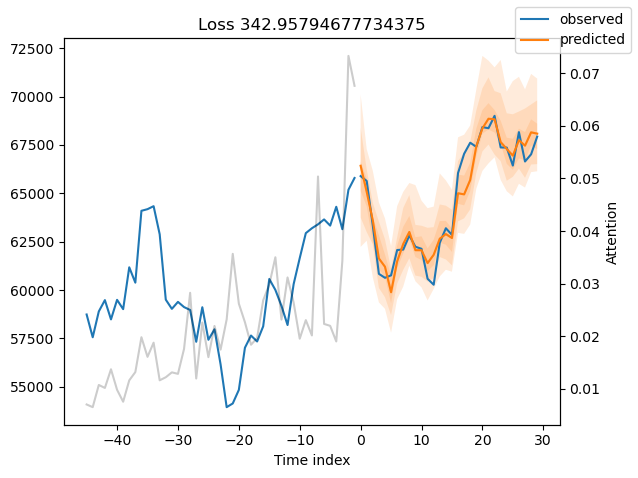

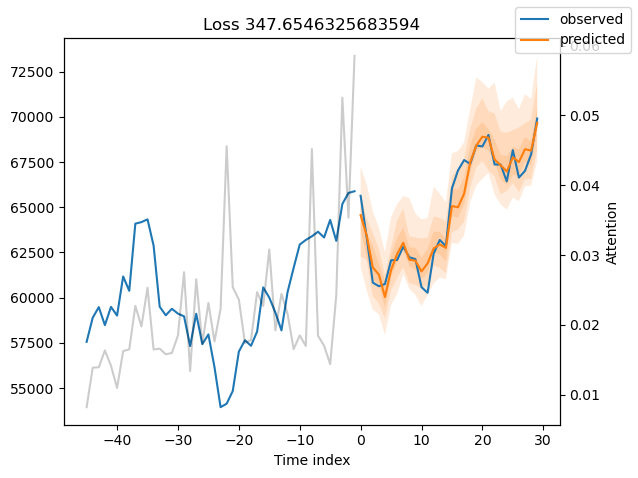

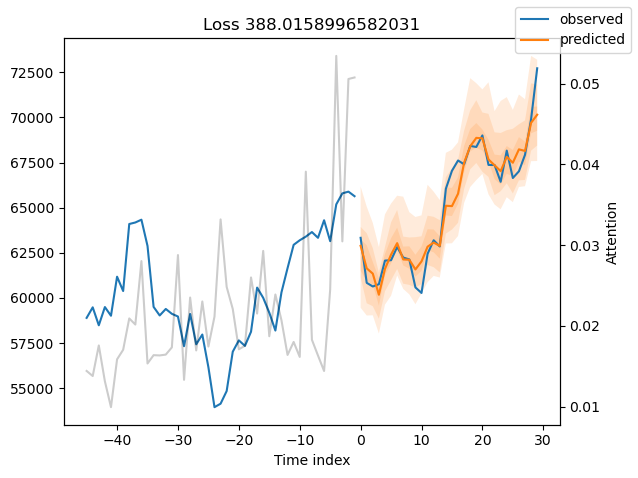

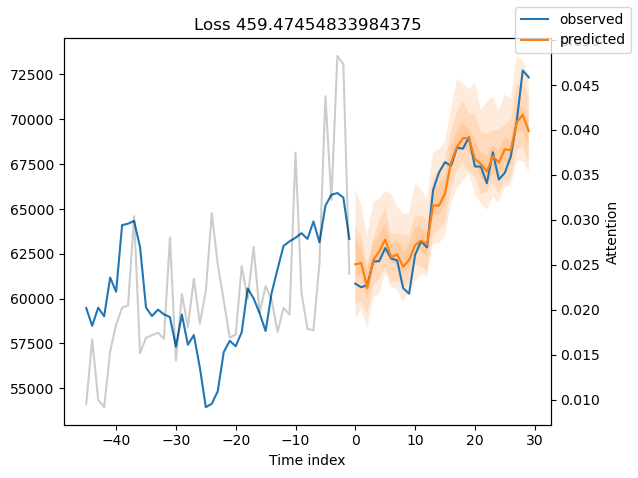

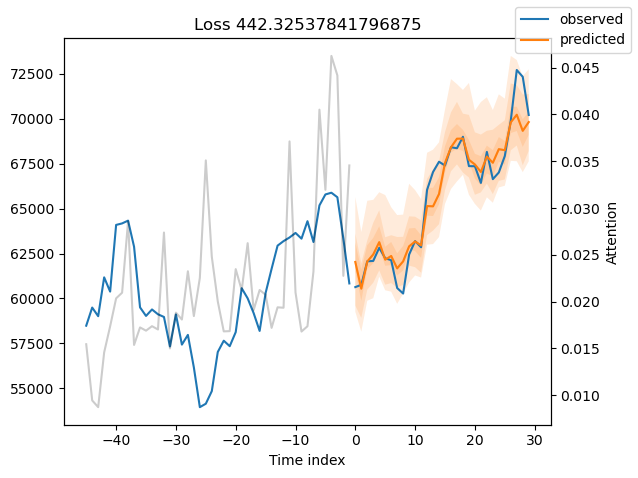

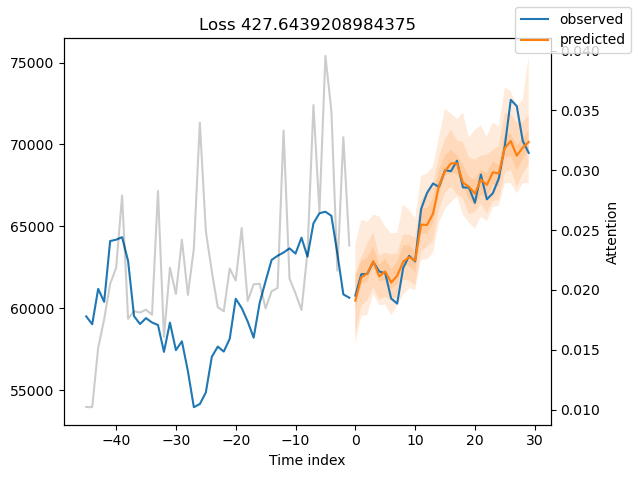

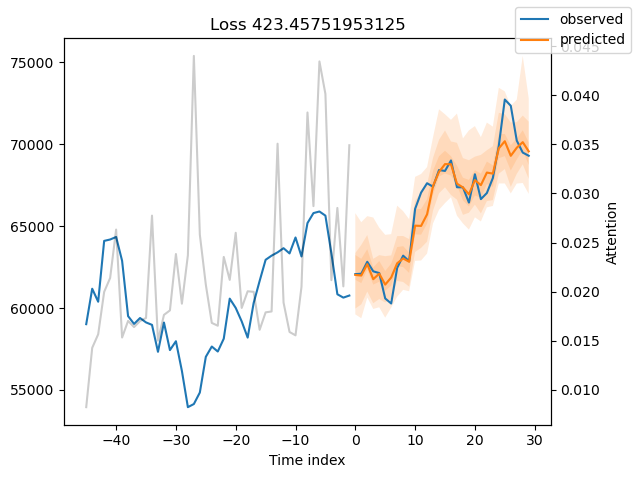

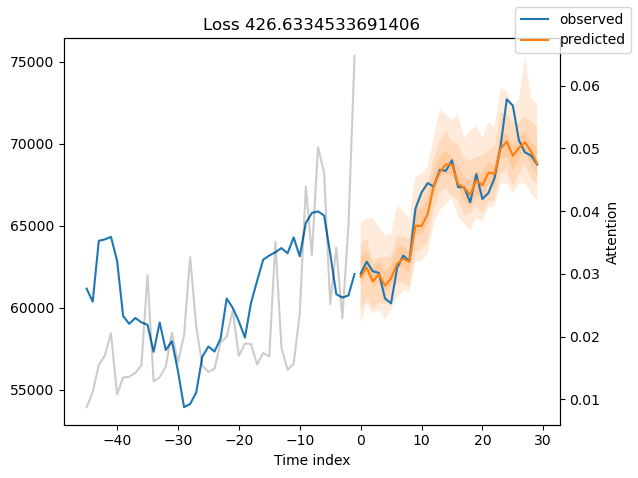

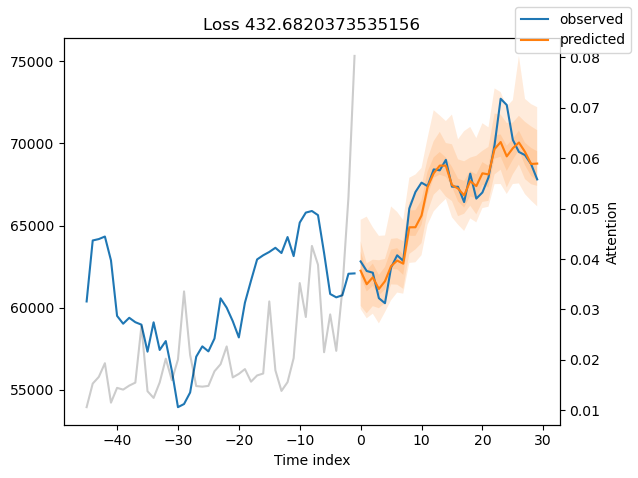

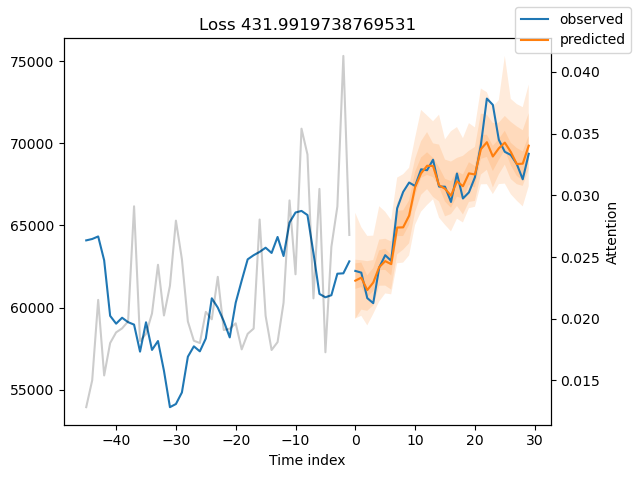

In [25]:
# Access the predictions from the named tuple
predictions_tensor = raw_predictions.output.prediction

# Get the number of available predictions (first dimension of the tensor)
num_predictions = predictions_tensor.size(0)

# Adjust loop to avoid out-of-bounds error
for idx in range(min(10, num_predictions)):  # Only iterate over available predictions
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

In [26]:
# compute the mean absolute error on validation set
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)])
val_prediction_results = best_tft.predict(val_dataloader)
print(f"Validation MAE: {(actuals - val_prediction_results.cpu().numpy()).abs().mean()}")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation MAE: 3663.310302734375


In [38]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
val_prediction_results = best_tft.predict(val_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [30]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
train_prediction_results = best_tft.predict(train_dataloader, mode="raw", return_x=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\Sathmika\anaconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


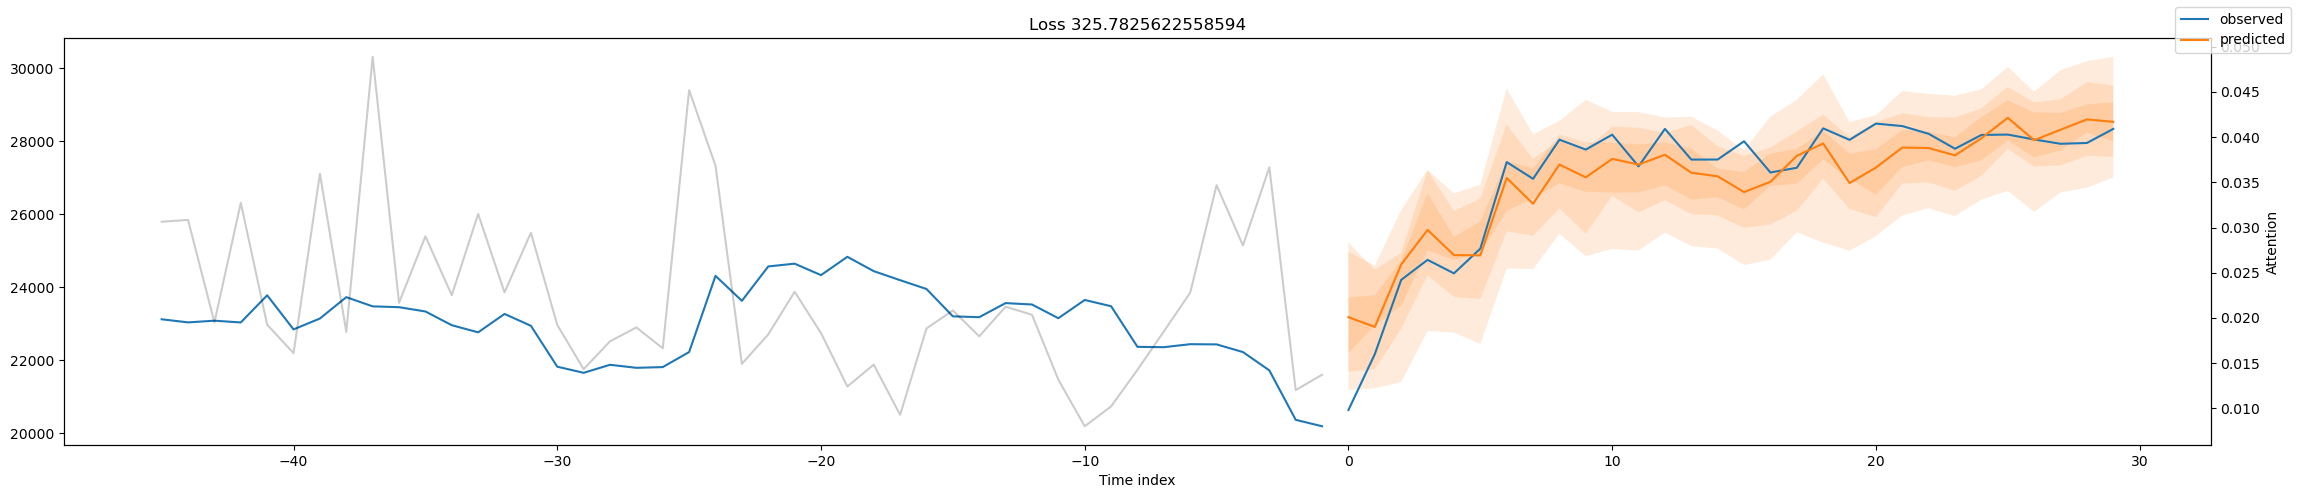

In [37]:
import matplotlib.pyplot as plt

# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(train_prediction_results.x, # network input
                            train_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)

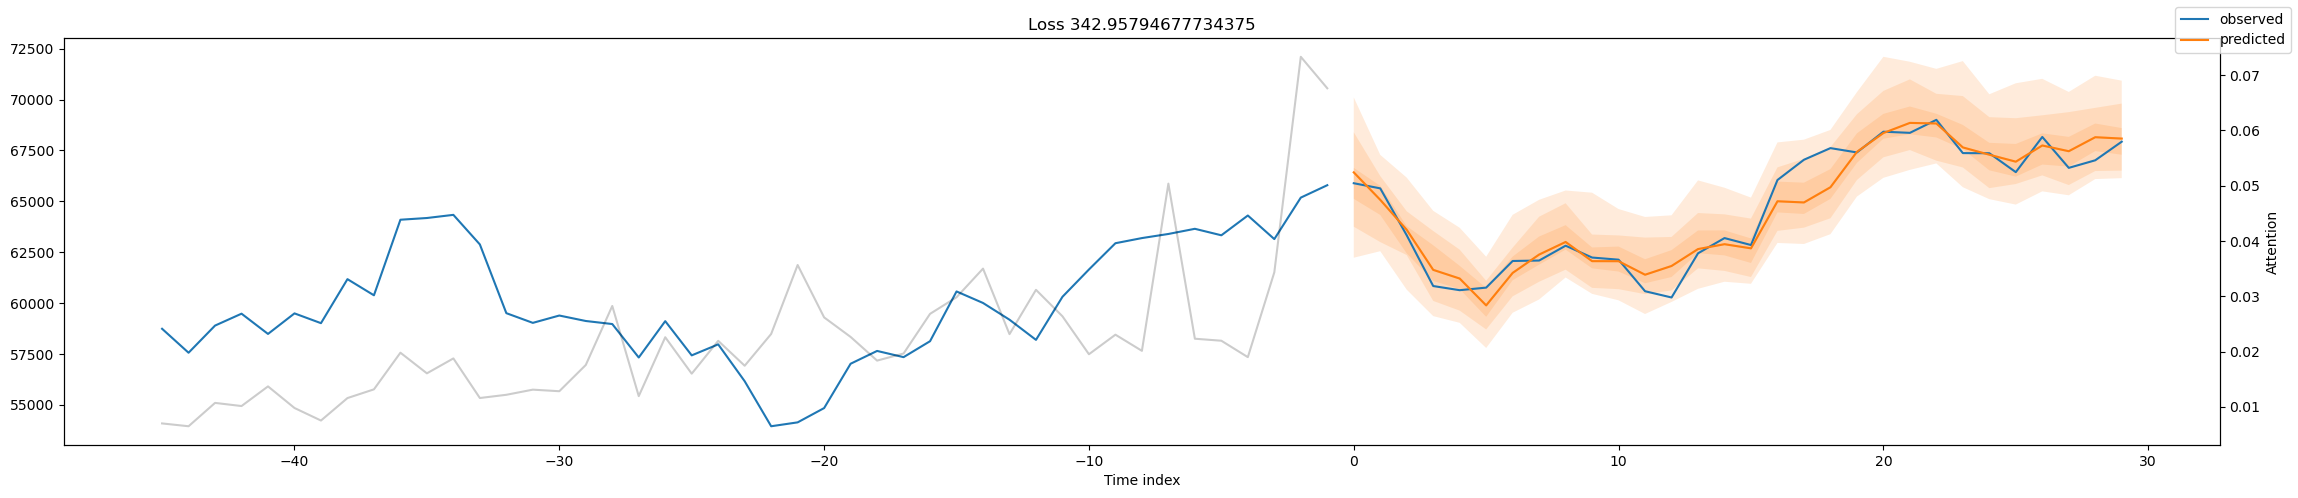

In [39]:
import matplotlib.pyplot as plt

# Plot actuals vs prediction and attention
# for idx in range(val_predictions.prediction.shape[0]):
for idx in range(1):
    fig, ax = plt.subplots(figsize=(23,5))
    best_tft.plot_prediction(val_prediction_results.x, # network input
                            val_prediction_results.output, # network output
                            idx=idx,
                            add_loss_to_title=True,
                            ax=ax)

In [29]:
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# Get actual and predicted values
actuals = torch.cat([y[0] for _, y in iter(val_dataloader)]).cpu().numpy()
val_prediction_results = best_tft.predict(val_dataloader).cpu().numpy()

# Compute MAE
mae = np.abs(actuals - val_prediction_results).mean()

# Compute RMSE
rmse = np.sqrt(mean_squared_error(actuals, val_prediction_results))

# Compute MAPE (handle division by zero)
mape = np.mean(np.abs((actuals - val_prediction_results) / np.clip(actuals, 1e-6, None))) * 100

# Compute R-squared (R²) score
r2 = r2_score(actuals, val_prediction_results)

# Compute MASE (if you have a naive forecast for comparison)
naive_forecast = np.roll(actuals, shift=1)  # Shifted actuals (naive forecast)
mase = mae / np.mean(np.abs(actuals - naive_forecast))  # Compare to naive MAE

# Print results
print(f"Validation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"MASE: {mase:.2f}")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation Metrics:
MAE:  3663.31
RMSE: 6264.74
MAPE: 3.86%
R² Score: 0.8041
MASE: 1.75


In [34]:
import torch

# Save only the model's state_dict (weights)
torch.save(best_tft.state_dict(), "tft_model_weights.pth")


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x500 with 1 Axes>,
 'decoder_variables': <Figure size 700x450 with 1 Axes>}

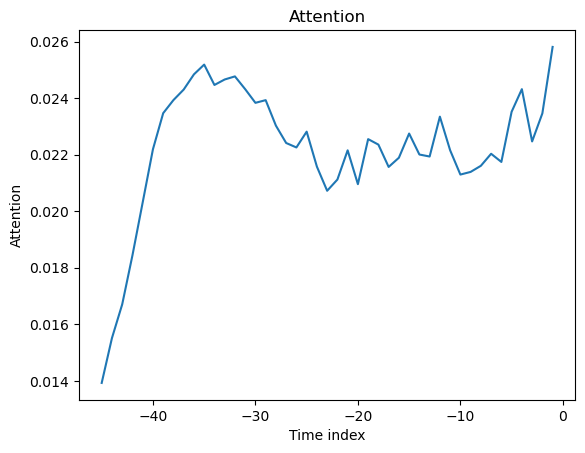

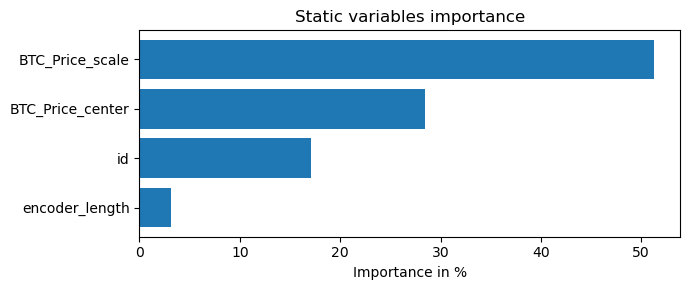

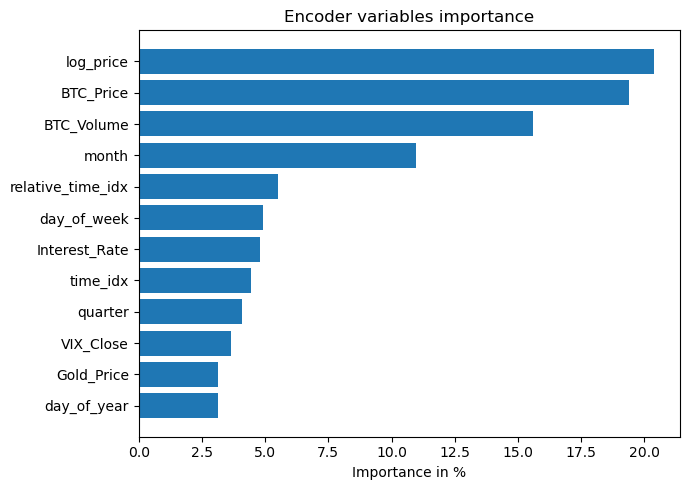

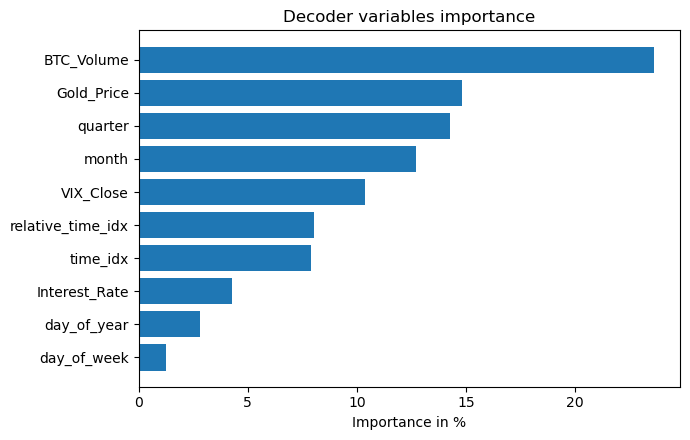

In [39]:
interpretation = best_tft.interpret_output(raw_predictions.output, reduction="sum")
best_tft.plot_interpretation(interpretation)